# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** first_name_1 last_name_1, first_name_2 last_name_2, first_name_3 last_name_3  
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

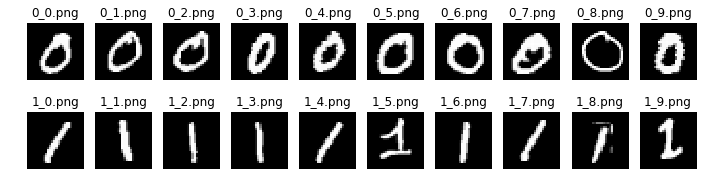

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 1.2 Fourier descriptors
Add your implementation and discussion

In [3]:
#import the libraries once and for all
import skimage.filters
import numpy as np
%matplotlib inline
from skimage import feature
from skimage import exposure
from scipy import ndimage
from skimage import measure
from skimage import filters
from skimage import morphology
from skimage import util
import math
import cmath


# function that computes the area enclosed by a set of points
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))
def PolyArea_list(x):
    return 0.5*np.abs(np.dot(x[:,0],np.roll(x[:,1],1))-np.dot(x[:,1],np.roll(x[:,0],1)))

In [4]:
# #Junk
# inverse_ft=[]
# inverse_ft_other=[]
# for k in range(0,len(us[0])):
#     N=float(len(us[0]))
# #     N=float(len(ft))
#     sqrt_N=np.sqrt(N)
#     somme=0
#     for i in range(0,int(len(us[0]))):
#         somme=somme+ft_other[i%len(ft_other)]*np.exp(complex(0,1.)*2*math.pi*i*k/N)
#     somme=somme/N
#     #temp=(sum([f*np.exp(2*complex(0,1.)*math.pi*l*k/N)/sqrt_N for (l, f) in enumerate(ft)]))
# #     temp=sum([f*np.exp(2*complex(0,1.)*math.pi*l*k/N) for (l, f) in enumerate(ft)])+sqrt_N
#     temp=sum([f*np.exp(2*complex(0,1.)*math.pi*l*k/N) for (l, f) in enumerate(ft)])
    
#     inverse_ft.append(temp)
#     inverse_ft_other.append(somme)
# #print(inverse_ft)

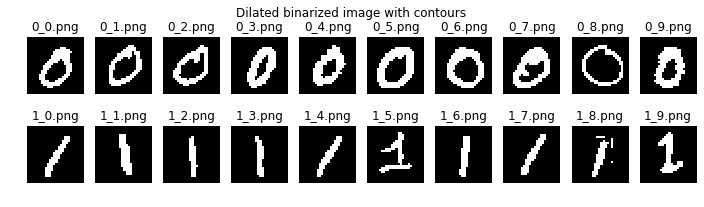

In [11]:
#binarization
zeros_bin=[]
ones_bin=[]
for im in zeros_im:
    zeros_bin.append(im[:]>100)
for im in ones_im:
    ones_bin.append(im[:]>100)
outer_0=[]
outer_1=[]

#Morphological operations, I'm not sure which one would fit best, for now I just dilate them all
zeros_dilated=[]
ones_dilated=[]
for im in zeros_bin:
#     im=morphology.binary_dilation(im,morphology.square(2))
    zeros_dilated.append(im)
for im in ones_bin:
#     im=morphology.binary_dilation(im,morphology.square(2))
    ones_dilated.append(im)

# Finding contours and taking the biggest contour as the one we want
for im in zeros_dilated:
    contours=measure.find_contours(im, 0.01)
    contours_areas=[PolyArea(x[:,0],x[:,1]) for x in contours]#computes the area of each contour found in the image
    outer_0.append(contours[np.argmax(np.asarray(contours_areas))])#finds the largest area contour
for im in ones_dilated:
    contours=measure.find_contours(im, 0.01)
    contours_areas=[PolyArea(x[:,0],x[:,1]) for x in contours]
    outer_1.append(contours[np.argmax(np.asarray(contours_areas))])

#plot everything
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
fig.suptitle('Dilated binarized image with contours')
for ax, im, nm in zip(axes[0], zeros_dilated, zeros_names):
# for ax, im, nm in zip(axes[1], zeros_bin, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, contour in zip(axes[0],outer_0):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)#x and y are in opposite in an image
for ax, im, nm in zip(axes[1], ones_dilated, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, contour in zip(axes[1],outer_1):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)#x and y are in opposite in an image
plt.show()

### creating the complex numbers from the contours
us_0=[]
us_1=[]
for cont in outer_0:
    us_0.append([complex(c[0],c[1]) for c in cont])
for cont in outer_1:
    us_1.append([complex(c[0],c[1]) for c in cont])

In [6]:
# #Plotting to check, we don't really need this anymore
# fig, axes = plt.subplots(3, len(zeros_im), figsize=(24, 8))
# for ax, im, nm in zip(axes[0], us_z, zeros_names):
#     ax.plot([u.imag for u in im],[u.real for u in im])
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[1], outer_z, zeros_names):
#     ax.plot( im[:, 1],im[:, 0], linewidth=2)
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[2], zeros_dilated, zeros_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im in zip(axes[2],us_z):
#         ax.plot([u.imag for u in im],[u.real for u in im])#x and y are in opposite in an image
# plt.show()

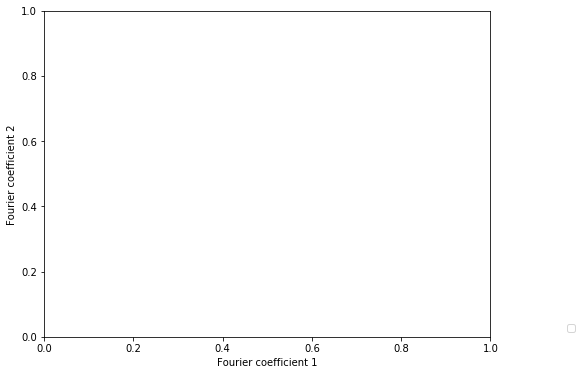

In [12]:
from mpl_toolkits.mplot3d import Axes3D
# Compute 10 fourier coefficients
ft_0=[]
ft_1=[]
for u in us_0:
    ftu=[]
    n=float(len(u))
    for l in range(0,10):
        temp=sum([u_i*np.exp(-complex(0,1.)*2*math.pi*k*l/n) for (k, u_i) in enumerate(u)])
        ftu.append(temp)
    ft_0.append(ftu)
for u in us_0:
    ftu=[]
    n=float(len(u))
    for l in range(0,10):
        temp=sum([u_i*np.exp(-complex(0,1.)*2*math.pi*k*l/n) for (k, u_i) in enumerate(u)])
        ftu.append(temp)
    ft_1.append(ftu)
# Take their norm
ft_0_norm=[[abs(u) for u in f] for f in ft_0]
ft_1_norm=[[abs(u) for u in f] for f in ft_1]

# And plot everything
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# fig = plt.figure(figsize=(12, 12))
# ax = fig.add_subplot(111, projection='3d')
for f in ft_0_norm:
    ax.plot(f[1], f[2], '*', markersize='20')
#     ax.scatter(f[1], f[2], f[3], marker='.')
#     ax.plot(f[1], f[2], '*')
for f in ft_1_norm:
    #ax.plot(f[1], f[2], '.')
#     ax.scatter(f[1], f[2], f[3], marker='^')
    ax.plot(f[1], f[2], '.',markersize='20')
ax.set_xlabel('Fourier coefficient 1')
ax.set_ylabel('Fourier coefficient 2')
ax.legend(zeros_names+ones_names, loc='lower right', bbox_to_anchor=(1.2, 0))
plt.show()

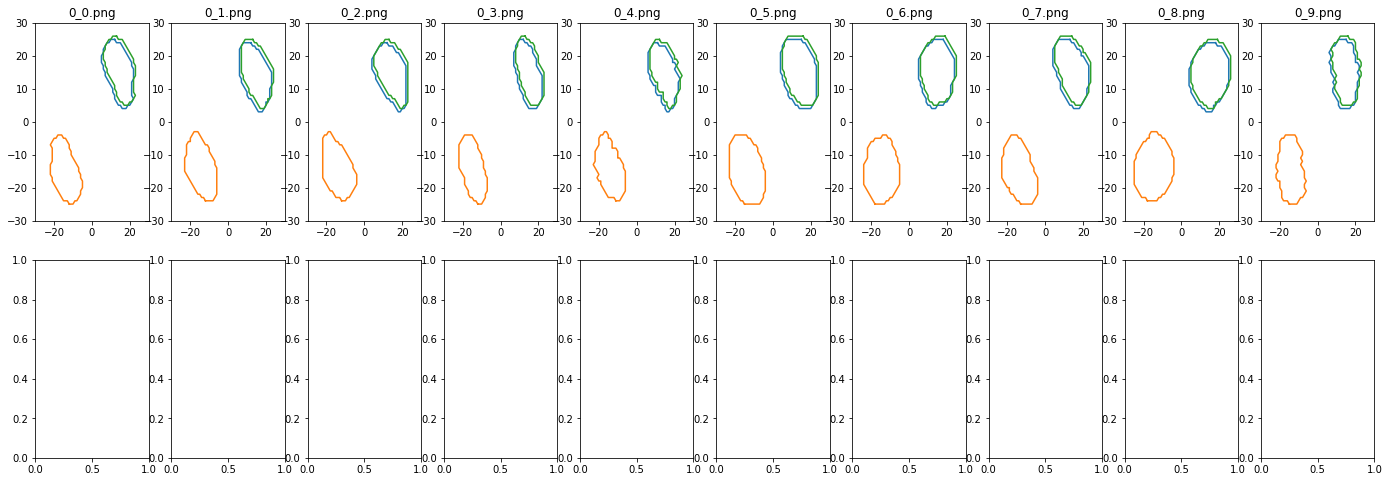

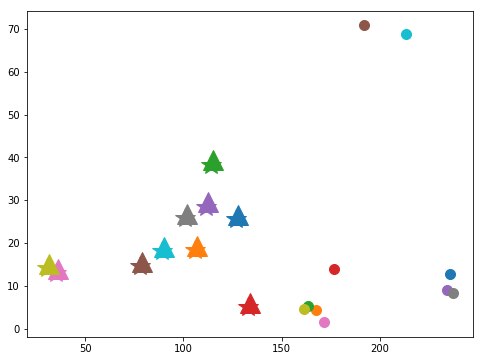

In [8]:
#assess rotation invariance
# rotate the complex numbers of the contours
xmax=30
xmin=-30
us_z_rotated=[]

for u in us_z:
    z_u=[]
    for z in u:
        z_u.append(np.exp(complex(0.,math.pi))*z)
    us_z_rotated.append(z_u)
us_z_rerotated=[]
for u in us_z_rotated:
    z_u=[]
    for z in u:
        z_u.append(np.exp(complex(0.,math.pi))*z)
    us_z_rerotated.append(z_u)
    
fig, axes = plt.subplots(2, len(zeros_im), figsize=(24, 8))
for ax, im1,im2,im3, nm in zip(axes[0], us_z, us_z_rotated,us_z_rerotated, zeros_names):
    ax.plot([u.imag for u in im1],[u.real for u in im1])
    ax.plot([u.imag for u in im2],[u.real for u in im2])
    ax.plot([u.imag+1 for u in im3],[u.real+1 for u in im3])
    
#     ax.axis('off')
    ax.set(xlim=(xmin, xmax), ylim=(xmin, xmax))
    ax.set_title(nm)
# for ax, im, nm in zip(axes[1], us_z_rotated, zeros_names):
#     ax.plot([u.imag for u in im],[u.real for u in im])
# #     ax.axis('off')
#     ax.set_title(nm)
plt.show()


ft_z_rotated=[]
for u in us_z_rotated:
    ftu=[]
    n=float(len(u))
    for l in range(0,10):
        temp=sum([u_i*np.exp(-complex(0,1.)*2*math.pi*k*l/n) for (k, u_i) in enumerate(u)])
        ftu.append(temp)
    ft_z_rotated.append(ftu)
    
ft_z_rotated_norm=[[abs(u) for u in f] for f in ft_z_rotated]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for f in ft_o_norm:
    ax.plot(f[1], f[2], '.', markersize='20')
for f in ft_z_rotated_norm:
    ax.plot(f[1], f[2], '*', markersize='20')
for f in ft_z_norm:
    ax.plot(f[1]+1, f[2]+1, '^', markersize='20')
plt.show()

In [9]:
#histogram
# fig, ax = plt.subplots(1, 2, figsize=(24, 6))
# ax[0].hist(test_ravel, bins=range(0,256,1))
# #ax[0].hist(zeros_im.ravel(), bins=256)
# ax[0].set_xlabel('Pixel intensity')
# ax[0].set_ylabel('Number of pixels')
# ax[0].set_title('256 bins histogram')

# fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
# for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)
# for ax, im, nm in zip(axes[1], zeros_bin, zeros_names):
#     ax.imshow(im, cmap='gray')
#     ax.axis('off')
#     ax.set_title(nm)
# plt.show()



### 1.3 Additional method(s)
Add your implementation and discussion

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

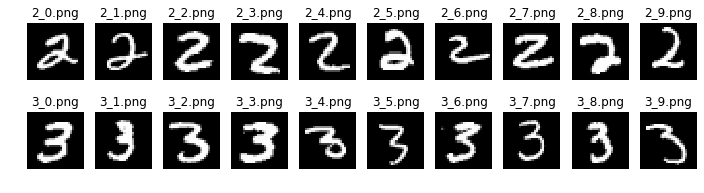

In [10]:
#  Load zeros
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load ones
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
Add your implementations and discussions here

In [ ]:
twos_bin=[]
threes_bin=[]
for im in twos_im:
    twos_bin.append(im[:]>100)
for im in ones_im:
    threes_bin.append(im[:]>100)
outer_2=[]
outer_3=[]